# 개인 프로젝트 : 구매 예측 프로젝트
    - 특정 시간대 별 구매 활성 여부를 예측

## 1. 데이터 로드

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("241218_analyze_project").getOrCreate()

24/12/19 10:28:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [108]:
df = spark.read.format("csv")\
    .option("header", 'true')\
    .option('inferSchema', 'true')\
    .option('encoding', 'CP949')\
    .load('data/거주지(소비자)기준 행정동별 상품판매.csv')

In [109]:
df.show(3)

+----------------+---------------------+-----------------------+----------------+------------------+-------------------+--------------------+------------------+------------------+
|기준년월(STD_YM)|행정동코드(ADSTRD_CD)|통계청상품코드(STAT_CD)|성별코드(SEX_CD)|연령대코드(AGE_CD)|시간대코드(TIME_CD)|구매_고객수(ACC_CNT)|구매건수(PURH_CNT)|구매금액(PURH_AMT)|
+----------------+---------------------+-----------------------+----------------+------------------+-------------------+--------------------+------------------+------------------+
|          201907|             11200720|                      E|               1|                 4|                  5|                   5|                16|            436000|
|          201809|             11140635|                      E|               1|                 7|                  4|                 179|                18|            110000|
|          201805|             11380632|                      J|               2|                 3|                  5|                   5|  

In [110]:
df.printSchema()

root
 |-- 기준년월(STD_YM): integer (nullable = true)
 |-- 행정동코드(ADSTRD_CD): integer (nullable = true)
 |-- 통계청상품코드(STAT_CD): string (nullable = true)
 |-- 성별코드(SEX_CD): integer (nullable = true)
 |-- 연령대코드(AGE_CD): integer (nullable = true)
 |-- 시간대코드(TIME_CD): integer (nullable = true)
 |-- 구매_고객수(ACC_CNT): integer (nullable = true)
 |-- 구매건수(PURH_CNT): integer (nullable = true)
 |-- 구매금액(PURH_AMT): integer (nullable = true)



In [111]:
df.count()

500

## 2. 데이터 전처리

### 1) 결측치 확인

In [112]:
from pyspark.sql.functions import col, isnan, when, count


df.select(
    [count(when(col(c).isNull() | isnan(col(c)), c)).alias(c) for c in df.columns]
).show()

+----------------+---------------------+-----------------------+----------------+------------------+-------------------+--------------------+------------------+------------------+
|기준년월(STD_YM)|행정동코드(ADSTRD_CD)|통계청상품코드(STAT_CD)|성별코드(SEX_CD)|연령대코드(AGE_CD)|시간대코드(TIME_CD)|구매_고객수(ACC_CNT)|구매건수(PURH_CNT)|구매금액(PURH_AMT)|
+----------------+---------------------+-----------------------+----------------+------------------+-------------------+--------------------+------------------+------------------+
|               0|                    0|                      0|               0|                 0|                  0|                   0|                 0|                 0|
+----------------+---------------------+-----------------------+----------------+------------------+-------------------+--------------------+------------------+------------------+



### 2) 데이터 열 이름 변경

In [113]:
# 열 이름에서 영어 코드만 추출
new_columns = [col.split("(")[-1].replace(")", "") for col in df.columns]  # 영어 코드만 추출
df = df.toDF(*new_columns)  # 새 열 이름 적용

# 결과 열 이름 확인
print(df.columns)

['STD_YM', 'ADSTRD_CD', 'STAT_CD', 'SEX_CD', 'AGE_CD', 'TIME_CD', 'ACC_CNT', 'PURH_CNT', 'PURH_AMT']


### 3) 분석에 활용할 데이터 선택

In [114]:
a_df = df.select("ADSTRD_CD", "STAT_CD", "SEX_CD", "AGE_CD", "TIME_CD", "ACC_CNT", "PURH_CNT")

In [115]:
a_df.show(3)

+---------+-------+------+------+-------+-------+--------+
|ADSTRD_CD|STAT_CD|SEX_CD|AGE_CD|TIME_CD|ACC_CNT|PURH_CNT|
+---------+-------+------+------+-------+-------+--------+
| 11200720|      E|     1|     4|      5|      5|      16|
| 11140635|      E|     1|     7|      4|    179|      18|
| 11380632|      J|     2|     3|      5|      5|       2|
+---------+-------+------+------+-------+-------+--------+
only showing top 3 rows



## 3. 데이터 기초 분석

### 1) 기술통계치 확인

In [129]:
a_df.describe().show()

+-------+------------------+-------+-------------------+------------------+------------------+------------------+-----------------+
|summary|         ADSTRD_CD|STAT_CD|             SEX_CD|            AGE_CD|           TIME_CD|           ACC_CNT|         PURH_CNT|
+-------+------------------+-------+-------------------+------------------+------------------+------------------+-----------------+
|  count|               500|    500|                500|               500|               500|               500|              500|
|   mean|    1.1435948382E7|   null|              1.526|             4.074|             3.932|            49.024|            99.12|
| stddev|185625.45644591315|   null|0.49982361618333826|1.6067630113832891|1.4026085060495268|178.35805171964188|373.8095514583904|
|    min|          11110530|      A|                  1|                 1|                 1|                 1|                1|
|    max|          11740700|      L|                  2|                 7| 

In [133]:
a_df.groupBy("ADSTRD_CD").count().orderBy("count", ascending=False).show()

+---------+-----+
|ADSTRD_CD|count|
+---------+-----+
| 11410565|    6|
| 11680690|    6|
| 11230705|    5|
| 11710647|    5|
| 11650530|    5|
| 11530540|    4|
| 11380552|    4|
| 11200560|    4|
| 11380530|    4|
| 11710650|    4|
| 11560540|    4|
| 11710642|    4|
| 11590680|    4|
| 11410655|    4|
| 11215730|    3|
| 11710610|    3|
| 11470600|    3|
| 11305590|    3|
| 11680700|    3|
| 11680521|    3|
+---------+-----+
only showing top 20 rows



In [136]:
a_df.groupBy("ADSTRD_CD").count().orderBy("count", ascending=False).count()

294

In [137]:
a_df.groupBy("STAT_CD").count().show()
a_df.groupBy("SEX_CD").count().show()
a_df.groupBy("TIME_CD").count().show()

+-------+-----+
|STAT_CD|count|
+-------+-----+
|      F|   17|
|      E|   95|
|      B|   87|
|      L|   79|
|      C|   30|
|      J|   35|
|      A|   99|
|      G|   19|
|      I|   39|
+-------+-----+

+------+-----+
|SEX_CD|count|
+------+-----+
|     1|  237|
|     2|  263|
+------+-----+

+-------+-----+
|TIME_CD|count|
+-------+-----+
|      1|   21|
|      6|   83|
|      3|  123|
|      5|  104|
|      4|  110|
|      2|   59|
+-------+-----+



### 2) 데이터 분포 확인

In [141]:
!pip install seaborn

In [145]:
import pandas as pd
pandas_df = a_df.select("ACC_CNT", "PURH_CNT", "SEX_CD", "AGE_CD", "TIME_CD").toPandas()

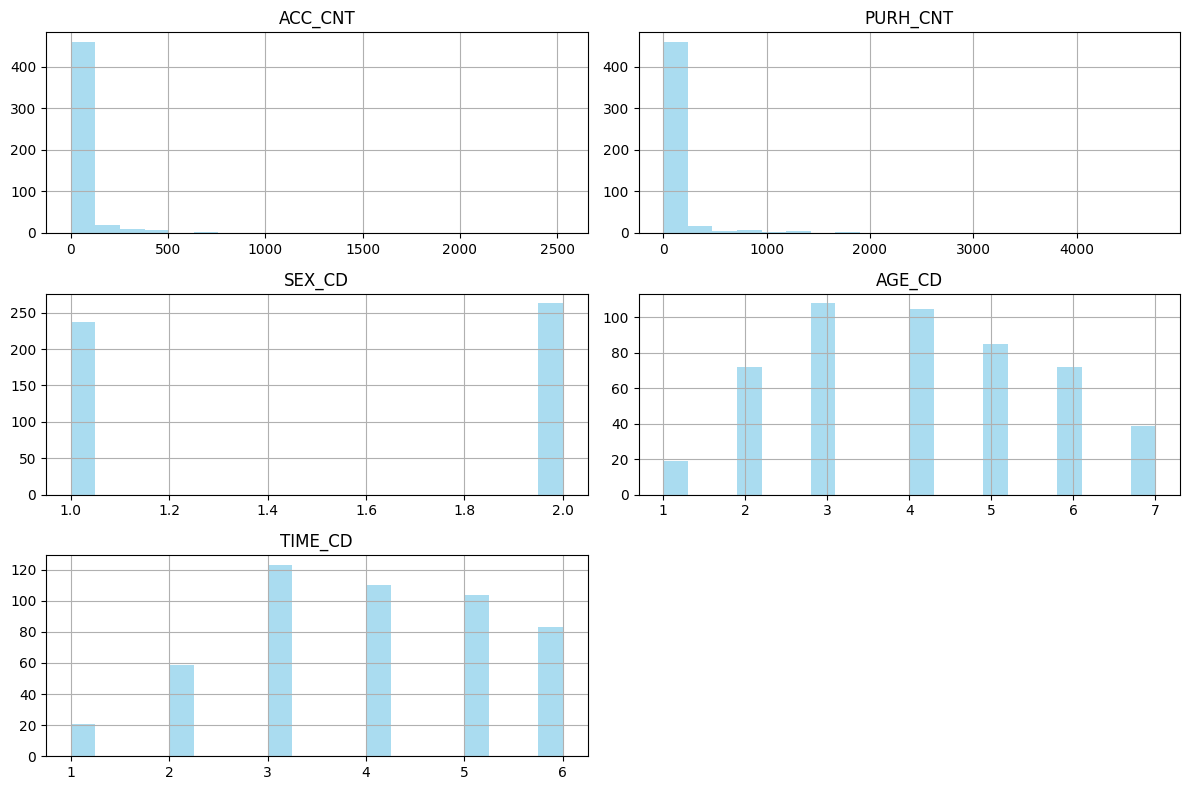

In [146]:
pandas_df.hist(bins=20, figsize=(12, 8), color='skyblue', alpha=0.7)
plt.tight_layout()
plt.show()

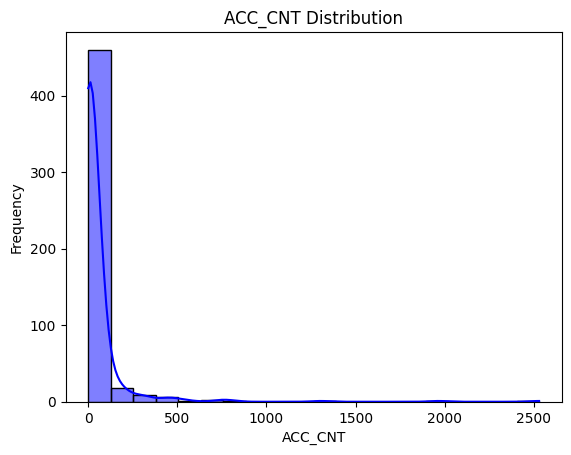

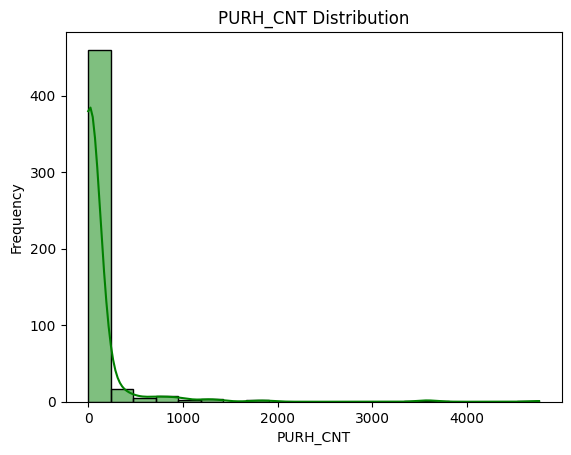

In [142]:
import seaborn as sns

# ACC_CNT 히스토그램
sns.histplot(data=pandas_df, x="ACC_CNT", bins=20, kde=True, color='blue')
plt.title("ACC_CNT Distribution")
plt.xlabel("ACC_CNT")
plt.ylabel("Frequency")
plt.show()

# PURH_CNT 히스토그램
sns.histplot(data=pandas_df, x="PURH_CNT", bins=20, kde=True, color='green')
plt.title("PURH_CNT Distribution")
plt.xlabel("PURH_CNT")
plt.ylabel("Frequency")
plt.show()


## 4. 모델 구축

### 1) 피쳐 선택 및 변환

In [116]:
from pyspark.ml.feature import StringIndexer

# 범주형 데이터 컬럼 리스트
category = ["ADSTRD_CD", "STAT_CD", "SEX_CD", "AGE_CD", "TIME_CD"]

# StringIndexer를 단계별로 생성
indexers = [
    StringIndexer(inputCol=col, outputCol=col + "_Index", handleInvalid="keep") 
    for col in category
]



### 2) 피처 벡터 어셈블

In [117]:
from pyspark.ml.feature import StringIndexer, VectorAssembler

# VectorAssembler 설정
assembler = VectorAssembler(
    inputCols=[col + "_Index" for col in category],
    outputCol="features"
)

### 3) 파이프라인 설정

In [118]:
from pyspark.ml import Pipeline

# 파이프라인 설정
pipeline = Pipeline(stages=indexers + [assembler])

# 파이프라인 실행
pipeline_model = pipeline.fit(a_df)
df_transformed = pipeline_model.transform(a_df)

# 결과 확인
df_transformed.select("features", "ACC_CNT").show()

+--------------------+-------+
|            features|ACC_CNT|
+--------------------+-------+
|[160.0,1.0,1.0,1....|      5|
|[55.0,1.0,1.0,5.0...|    179|
|[90.0,5.0,0.0,0.0...|      5|
|[66.0,2.0,1.0,4.0...|    331|
|[55.0,2.0,1.0,4.0...|      9|
|[86.0,3.0,0.0,5.0...|     18|
|[115.0,0.0,0.0,4....|      1|
|[70.0,0.0,1.0,1.0...|      3|
|[36.0,1.0,0.0,0.0...|      3|
|[34.0,1.0,1.0,1.0...|      3|
|[252.0,3.0,1.0,1....|      2|
|[59.0,2.0,1.0,0.0...|      7|
|[52.0,8.0,0.0,5.0...|     10|
|[103.0,2.0,1.0,2....|     59|
|[145.0,3.0,1.0,2....|      1|
| (5,[0,2],[9.0,1.0])|      3|
|[139.0,6.0,0.0,5....|      1|
|[93.0,3.0,1.0,2.0...|      1|
|[5.0,4.0,1.0,1.0,...|     15|
|[80.0,1.0,1.0,0.0...|    288|
+--------------------+-------+
only showing top 20 rows



### 4) 데이터 분할

In [119]:
train_data, test_data = df_transformed.randomSplit([0.8, 0.2], seed=42)

In [120]:
train_data.show(5), test_data.show(5)

+---------+-------+------+------+-------+-------+--------+---------------+-------------+------------+------------+-------------+--------------------+
|ADSTRD_CD|STAT_CD|SEX_CD|AGE_CD|TIME_CD|ACC_CNT|PURH_CNT|ADSTRD_CD_Index|STAT_CD_Index|SEX_CD_Index|AGE_CD_Index|TIME_CD_Index|            features|
+---------+-------+------+------+-------+-------+--------+---------------+-------------+------------+------------+-------------+--------------------+
| 11110530|      I|     1|     3|      5|     49|       3|          136.0|          4.0|         1.0|         0.0|          2.0|[136.0,4.0,1.0,0....|
| 11110540|      E|     1|     6|      5|     91|       4|           49.0|          1.0|         1.0|         4.0|          2.0|[49.0,1.0,1.0,4.0...|
| 11110560|      F|     2|     3|      4|      6|       1|          137.0|          8.0|         0.0|         0.0|          1.0|[137.0,8.0,0.0,0....|
| 11110600|      A|     2|     5|      4|      9|      22|           50.0|          0.0|         0.0

(None, None)

### 5) 모델 학습(Linear Regression)

In [121]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol="features", labelCol="ACC_CNT")
lr_model = lr.fit(train_data)

24/12/19 13:25:37 WARN Instrumentation: [701411df] regParam is zero, which might cause numerical instability and overfitting.


In [122]:
predictions = lr_model.transform(test_data)

## 4. 데이터 분석

### 1) 행정구역 별 구매 예측

#### 1.1) 예측값 확인

In [123]:
predictions.select("ADSTRD_CD", "prediction").orderBy("prediction", ascending=False).show(10)

+---------+-----------------+
|ADSTRD_CD|       prediction|
+---------+-----------------+
| 11320512|77.88206386564809|
| 11710642|75.87627665537283|
| 11410565|75.51860343673721|
| 11200615|70.54609267062406|
| 11200560|69.67071953739536|
| 11590680|69.28904420836514|
| 11470600|68.73144979897468|
| 11710647|67.32149781065407|
| 11170690| 66.8042301292542|
| 11320670|66.73910666661521|
+---------+-----------------+
only showing top 10 rows



#### 1.2) 실제 데이터 확인

In [124]:
# 예측값과 실제값 비교
predictions.select("ADSTRD_CD", "ACC_CNT", "prediction").orderBy("prediction", ascending=False).show(15)

+---------+-------+------------------+
|ADSTRD_CD|ACC_CNT|        prediction|
+---------+-------+------------------+
| 11320512|     13| 77.88206386564809|
| 11710642|     14| 75.87627665537283|
| 11410565|      8| 75.51860343673721|
| 11200615|      1| 70.54609267062406|
| 11200560|      1| 69.67071953739536|
| 11590680|      6| 69.28904420836514|
| 11470600|      5| 68.73144979897468|
| 11710647|      1| 67.32149781065407|
| 11170690|     42|  66.8042301292542|
| 11320670|     64| 66.73910666661521|
| 11140635|      9| 66.19127025704279|
| 11260630|     14| 65.43731520773986|
| 11530540|     11| 65.37967163929646|
| 11530540|      3| 63.12835577526348|
| 11545620|     11|63.086127587070706|
+---------+-------+------------------+
only showing top 15 rows



### 1.3) 모델 성능 평가

In [125]:
from pyspark.ml.evaluation import RegressionEvaluator

# RMSE 계산
rmse_evaluator = RegressionEvaluator(
    labelCol="ACC_CNT", predictionCol="prediction", metricName="rmse"
)
rmse = rmse_evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# R² 계산
r2_evaluator = RegressionEvaluator(
    labelCol="ACC_CNT", predictionCol="prediction", metricName="r2"
)
r2 = r2_evaluator.evaluate(predictions)
print(f"R-Squared (R²): {r2}")

Root Mean Squared Error (RMSE): 101.40995564054914
R-Squared (R²): -0.02882039175085227


- 실제 데이터 예측을 잘 하지 못하며, 모델 성능 평가 시에도 모델의 성능이 나쁜 것으로 나타남. 

### 1.4) 데이터 시각화

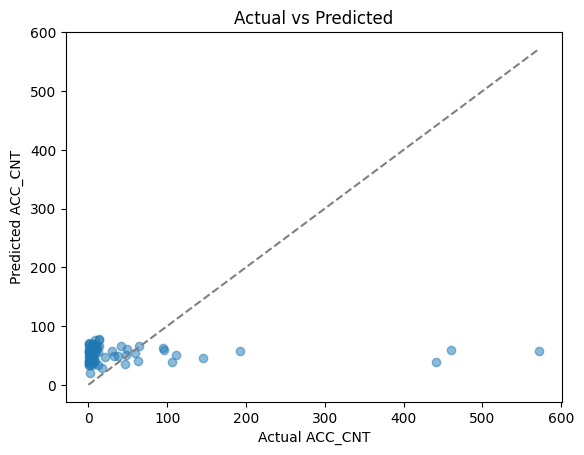

In [128]:
import matplotlib.pyplot as plt
import pandas as pd


pd_df = predictions.select("ACC_CNT", "prediction").toPandas()

# 예측값 vs 실제값
plt.scatter(pd_df["ACC_CNT"], pd_df["prediction"], alpha=0.5)
plt.plot([0, max(pd_df["ACC_CNT"])], [0, max(pd_df["ACC_CNT"])], color='grey', linestyle='--')
plt.xlabel("Actual ACC_CNT")
plt.ylabel("Predicted ACC_CNT")
plt.title("Actual vs Predicted")
plt.show()


### 2. 시간대별 구매 예측

In [176]:
# VectorAssembler로 피처 생성
assembler = VectorAssembler(
    inputCols=["TIME_CD"],  # 모델 입력 피처
    outputCol="features"
)
time_df = assembler.transform(a_df)

# 데이터 분할
train_df, test_df = time_df.randomSplit([0.8, 0.2], seed=42)

# 모델 정의 및 학습
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol="features", labelCol="ACC_CNT")  # 타깃 변수는 ACC_CNT
lr_model = lr.fit(train_df)

# 예측 수행
predictions = lr_model.transform(test_df)

# 결과 확인
predictions.select("TIME_CD", "ACC_CNT", "prediction").show()


+-------+-------+-----------------+
|TIME_CD|ACC_CNT|       prediction|
+-------+-------+-----------------+
|      5|      8|46.27519002701592|
|      3|     48|54.08535761710699|
|      5|     33|46.27519002701592|
|      3|     10|54.08535761710699|
|      5|      1|46.27519002701592|
|      1|      9|61.89552520719807|
|      6|     12|42.37010623197038|
|      2|    572|57.99044141215253|
|      1|     42|61.89552520719807|
|      4|     49|50.18027382206145|
|      5|      1|46.27519002701592|
|      6|      2|42.37010623197038|
|      6|      3|42.37010623197038|
|      2|      1|57.99044141215253|
|      4|      1|50.18027382206145|
|      3|      6|54.08535761710699|
|      4|      4|50.18027382206145|
|      4|     95|50.18027382206145|
|      3|      1|54.08535761710699|
|      6|     12|42.37010623197038|
+-------+-------+-----------------+
only showing top 20 rows



24/12/19 16:52:54 WARN Instrumentation: [af86b43f] regParam is zero, which might cause numerical instability and overfitting.


In [177]:
from pyspark.ml.evaluation import RegressionEvaluator

# RMSE 계산
rmse_evaluator = RegressionEvaluator(labelCol="ACC_CNT", predictionCol="prediction", metricName="rmse")
rmse = rmse_evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# R² 계산
r2_evaluator = RegressionEvaluator(labelCol="ACC_CNT", predictionCol="prediction", metricName="r2")
r2 = r2_evaluator.evaluate(predictions)
print(f"R-Squared (R²): {r2}")

Root Mean Squared Error (RMSE): 100.07515098476581
R-Squared (R²): -0.0019150173147115535


### 추가 예정
1) 기준연월별 분석
2) 행정구역별 구매 > 행정구역별 구매자수or금액 sum한 후 다시 예측
3) 연속형 변수 describe 및 데이터 탐색